In [1]:
import pandas as pd, numpy as np
from pathlib import Path
from fastprogress import progress_bar
from functools import partial
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=14, progress_bar=True)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
cols = ['los_pick_id', 'los_order_id', 'art_id', 'to_pick', 'weight', 'volume', 'tour_id',
       'box_position_on_cart', 'box_type', 'pick_start_date', 'pick_end_date']

pdate = partial(pd.to_datetime, format=r'%Y-%m-%d-%H.%M.%S.%f', errors='coerce')

## join data
and compute some features

In [3]:
for i, f in progress_bar(enumerate(Path('data/').glob('Picks_*')), total=6):
    d = (pd.read_csv(f, sep=';',
                     parse_dates=['pick_start_date', 'pick_end_date'],
                     usecols=cols,
                     date_parser=pdate)
         .dropna(subset=['pick_start_date', 'pick_end_date', 'tour_id'])
         .assign(    # extra features and handle NaN's for continious
             pick_time=lambda x: x.pick_end_date.sub(x.pick_start_date).dt.total_seconds(),
             timeofday=lambda x: (x.pick_start_date.dt.hour*3600 + 
                                  x.pick_start_date.dt.minute*60 + 
                                  x.pick_start_date.dt.second),
             weekday=lambda x: x.pick_start_date.dt.weekday,
             month=lambda x: x.pick_start_date.dt.month,
             monthday=lambda x: x.pick_start_date.dt.day,
         )
        ).query('pick_start_date < pick_end_date')  # sanity check, data has mistakes
    params = dict(
        path_or_buf='data/all_picks.csv.gz',
        index=False,
        compression='gzip',
        header=False,
        mode='a'
    )
    if i == 0:
        d.to_csv(**{**params, 'mode': 'w', 'header': True})
    else:
        d.to_csv(**params)

## Features
(were added and removed iteratively: do we have this data for real life prediction? what can matter here?…)

In [3]:
df = pd.read_csv('data/all_picks.csv.gz',
                 parse_dates=['pick_start_date', 'pick_end_date']
                ).sort_values('pick_start_date')

### tour

In [5]:
def make_tour_individual_feats(d):
    d['is_train'] = d.pick_start_date.lt('2020-02-01').any()
    d['picks_done_on_tour'] = np.arange(len(d))
#     # we can't know it when the tour starts
#     d['time_after_prev_pick'] = (d.pick_end_date
#                                  .sub(d.pick_start_date.shift(1))
#                                  .dt.total_seconds()
#                                 )    
    d['items_on_tour'] = d.to_pick.cumsum()
    d['weigh_on_tour'] = d.weight.mul(d.to_pick).cumsum()
    d['volume_on_tour'] = d.volume.mul(d.to_pick).cumsum()
    d['orders_picking_on_tour'] = d.pick_start_date.apply(
        lambda t: d.loc[d.pick_start_date < t]
            .los_order_id
            .drop_duplicates()
            .count()
    )
    d['weight_cum_std'] = d.pick_start_date.apply(
        lambda t: d.loc[d.pick_start_date <= t].weight.std()
    ).fillna(0)
    d['volume_cum_std'] = d.pick_start_date.apply(
        lambda t: d.loc[d.pick_start_date <= t].volume.std()
    ).fillna(0)
    return d

In [6]:
df = df.groupby('tour_id').parallel_apply(make_tour_individual_feats)

In [4]:
box_types = df.box_type.drop_duplicates().values

In [5]:
def tour_feats(d):
    return pd.Series(dict(
        total_tour_orders=d.los_order_id.drop_duplicates().count(),
        total_tour_picks=len(d),
        total_tour_items=d.to_pick.sum(),
        tour_start_date=d.pick_start_date.min()
    )).append(
#         assume all order is in 1 box?
        d.drop_duplicates('los_order_id')
        .box_type
        .value_counts()
        .reindex(box_types)
        .add_prefix('total_tour_box_')
        .fillna(0)
    )

In [6]:
tours = df.groupby('tour_id').parallel_apply(tour_feats)

In [17]:
# tours.to_csv('data/tour_feats.csv.gz', index_label='tour_id', compression='gzip')

### order

In [11]:
def order_feats(d):
    return pd.Series(dict(
        order_total_picks=len(d),
        order_total_items=d.to_pick.sum(),
        order_total_weigh=d.weight.mul(d.to_pick).sum(),
        order_total_volume=d.volume.mul(d.to_pick).sum(),
    ))

In [12]:
orders = df.groupby('los_order_id').parallel_apply(order_feats)

In [13]:
# orders.to_csv('data/orders_feats.csv.gz', index_label='los_order_id', compression='gzip')

In [14]:
def make_order_individual_feats(d):
    d['picks_done_in_order'] = np.arange(len(d))   
    d['items_in_order'] = d.to_pick.cumsum()
    d['weigh_in_order'] = d.weight.mul(d.to_pick).cumsum()
    d['vol_in_order'] = d.volume.mul(d.to_pick).cumsum()
    d['weight_order_cum_std'] = d.pick_start_date.apply(
        lambda t: d.loc[d.pick_start_date <= t].weight.std()
    ).fillna(0)
    d['volume_order_cum_std'] = d.pick_start_date.apply(
        lambda t: d.loc[d.pick_start_date <= t].volume.std()
    ).fillna(0)
    return d

In [15]:
df = df.groupby('los_order_id').parallel_apply(make_order_individual_feats)

In [16]:
# df.to_csv('data/picks_feats.csv.gz', index=False, compression='gzip')

In [96]:
# df.query('is_train').to_csv('data/trn_picks_feats.csv.gz', index=False, compression='gzip')

In [97]:
# df.query('not is_train').to_csv('data/val_picks_feats.csv.gz', index=False, compression='gzip')

## explore data

In [46]:
s = pd.read_csv('data/picks_feats.csv.gz',
                parse_dates=['pick_start_date', 'pick_end_date']
               ).sample(100000)

In [47]:
corr_columns = [
    'pick_time', 'to_pick', 'weight', 'volume', 'box_position_on_cart',
    'timeofday', 'weekday', 'monthday', 'picks_done_on_tour', 'items_on_tour',
    'weigh_on_tour', 'volume_on_tour', 'orders_picking_on_tour',
    'weight_cum_std', 'volume_cum_std', 'picks_done_in_order',
    'items_in_order', 'weigh_in_order', 'vol_in_order',
    'weight_order_cum_std', 'volume_order_cum_std',
]

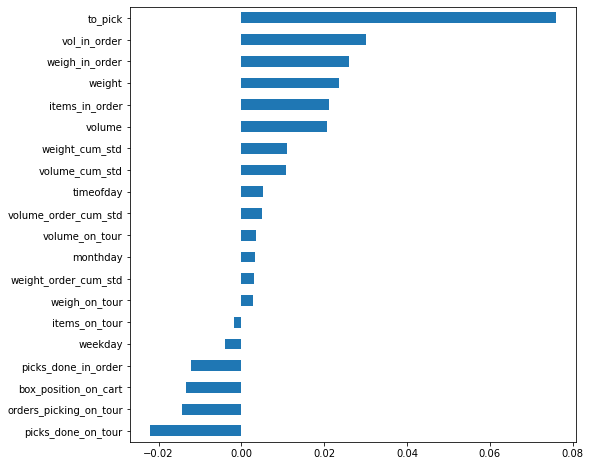

In [30]:
s[corr_columns].corr().pick_time.drop('pick_time').sort_values().plot(kind='barh', figsize=(8,8))

In [25]:
s.pick_time.quantile(0.99)

65.57539625999985

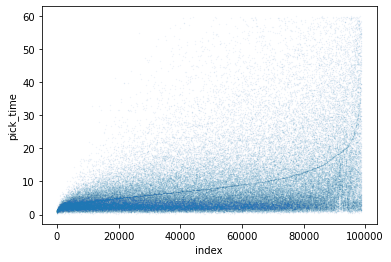

In [24]:
(s.set_index('art_id')
 .join(s.groupby('art_id').pick_time.mean().rename('mpick'), how='left')
 .sort_values('mpick')
 .query('pick_time < 60')
 .reset_index()
 .reset_index()
 .plot('index', 'pick_time', kind='scatter', s=0.1, alpha=0.1))

/home/nr/Desktop/ml_test/env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


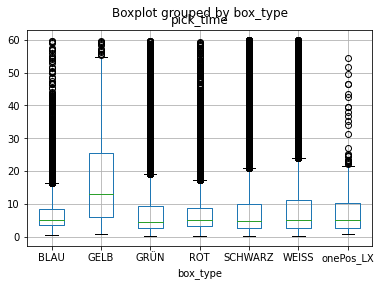

In [26]:
s.query('pick_time < 60').boxplot('pick_time', by='box_type')

In [32]:
def scatter(c: str, d=s):
    d.query('pick_time < 60').plot(c, 'pick_time', kind='scatter', s=0.5, alpha=0.3)

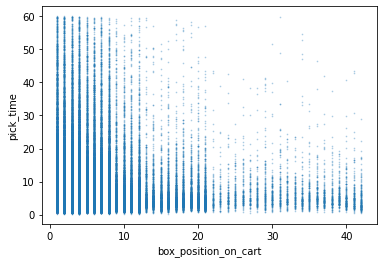

In [33]:
scatter('box_position_on_cart')

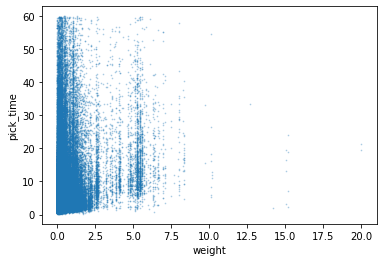

In [34]:
scatter('weight')

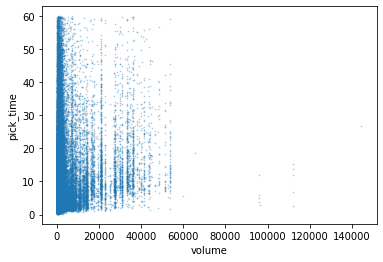

In [35]:
scatter('volume')

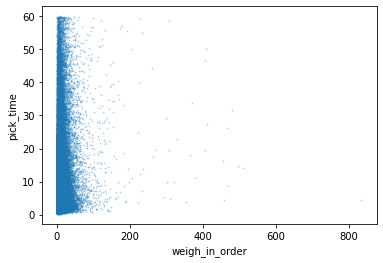

In [39]:
scatter('weigh_in_order')

In [49]:
import matplotlib.pyplot as plt

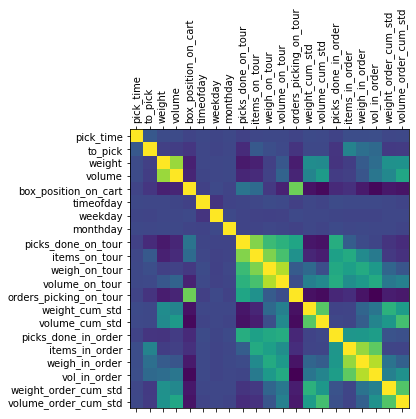

In [62]:
plt.rcParams['figure.figsize'] = (5,5)
plt.matshow(s[corr_columns].corr().values)
plt.xticks(ticks=range(len(corr_columns)), labels=corr_columns, rotation=90)
plt.yticks(ticks=range(len(corr_columns)), labels=corr_columns)
plt.show()

## Model

In [3]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
import matplotlib.pyplot as plt

In [4]:
df_all = pd.read_csv('data/picks_feats.csv.gz')

In [5]:
df_all.columns

Index(['los_pick_id', 'los_order_id', 'art_id', 'to_pick', 'weight', 'volume',
       'tour_id', 'box_position_on_cart', 'box_type', 'pick_start_date',
       'pick_end_date', 'pick_time', 'timeofday', 'weekday', 'month',
       'monthday', 'is_train', 'picks_done_on_tour', 'items_on_tour',
       'weigh_on_tour', 'volume_on_tour', 'orders_picking_on_tour',
       'weight_cum_std', 'volume_cum_std', 'picks_done_in_order',
       'items_in_order', 'weigh_in_order', 'vol_in_order',
       'weight_order_cum_std', 'volume_order_cum_std'],
      dtype='object')

In [6]:
categories = ['box_type', 'weekday', 'art_id']
intervals = [
    'to_pick', 'weight', 'volume', 'box_position_on_cart', 
    'timeofday', 'weekday', 'month', 'monthday', 
    'picks_done_on_tour', 'items_on_tour', 'weigh_on_tour',
    'volume_on_tour', 'orders_picking_on_tour', 'weight_cum_std',
    'volume_cum_std', 'picks_done_in_order', 'items_in_order',
    'weigh_in_order', 'vol_in_order', 'weight_order_cum_std',
    'volume_order_cum_std',
]

### Baseline for a short period of time

January 2020  
Let's just put it to XGBoost and see what happens. **Validation set — last picks this month**

In [136]:
tours = pd.read_csv('data/tour_feats.csv.gz', index_col='tour_id', parse_dates=['tour_start_date']
                   ).query('tour_start_date.dt.month == 1')

In [137]:
df = df_all.loc[df_all.tour_id.isin(tours.index)
               ].merge(tours, left_on='tour_id', right_index=True, how='left'
               ).copy()

In [138]:
df.is_train = df.tour_start_date < '2020-01-20'

In [7]:
prepr = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categories),
    ('asis', 'passthrough', intervals),
])

In [140]:
X = prepr.fit_transform(df.query('is_train'))
Y = df.query('is_train').pick_time.values

In [141]:
X_val = prepr.transform(df.query('not is_train'))
Y_val = df.query('not is_train').pick_time.values

In [144]:
xgb = XGBRFRegressor(random_state=42, verbosity=3, tree_method='gpu_hist',
                     max_depth=10, sampling_method='gradient_based', subsample=0.7)
xgb.fit(X, Y)

[00:57:31] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:1061: [GPU Hist]: Configure
[00:57:31] DEBUG: /workspace/src/common/device_helpers.cu:38: Running nccl init on: 10.0
[00:57:31] ======== Monitor: DenseCuts ========
[00:57:31] Init: 0.000705s, 1 calls @ 705us

[00:57:31] ======== Monitor: HistogramCuts ========
[00:57:40] ======== Monitor: Learner ========
[00:57:40] Configure: 0.000466s, 1 calls @ 466us

[00:57:40] GetGradient: 0.003303s, 1 calls @ 3303us

[00:57:40] PredictRaw: 0.000204s, 1 calls @ 204us

[00:57:40] UpdateOneIter: 8.76828s, 1 calls @ 8768278us

[00:57:40] ======== Monitor: GBTree ========
[00:57:40] BoostNewTrees: 8.76427s, 1 calls @ 8764266us

[00:57:40] CommitModel: 2e-06s, 1 calls @ 2us

[00:57:40] ======== Device 0 Memory Allocations:  ========
[00:57:40] Peak memory usage: 952MiB
[00:57:40] Number of allocations: 559894
[00:57:40] ======== Monitor: updater_gpu_hist ========
[00:57:40] InitData: 0.202676s, 100 calls @ 202676us

[00:57:40] InitDataOnce: 0.2

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=nan,
               monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', random_state=42, reg_alpha=0,
               sampling_method='gradient_based', scale_pos_weight=1,
               subsample=0.7, tree_method='gpu_hist', validate_parameters=1,
               verbosity=3)

In [145]:
xgb.score(X, Y)

0.4992687376933693

In [146]:
pred = df.query('not is_train').assign(
    pick_start_date=lambda x: pd.to_datetime(x.pick_start_date),
    y_pred=xgb.predict(X_val),
    se=lambda x: x.pick_time.sub(x.y_pred).pow(2),
).copy()

In [147]:
rmse_daily = pred.groupby(pred.pick_start_date.dt.day).apply(lambda d: d.se.mean()).pow(0.5)

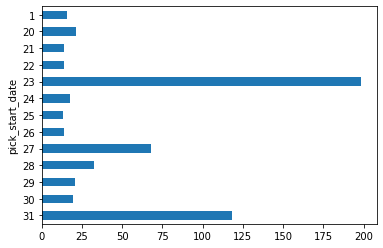

In [148]:
rmse_daily.iloc[::-1].plot(kind='barh')

**What was goind on that days???**  
— High variance. Outliers? Errors? It is not a specific weekday, there were same numbers of tours, picks, volumes

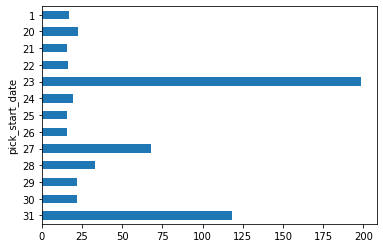

In [165]:
pred.groupby(pred.pick_start_date.dt.day).pick_time.std().iloc[::-1].plot(kind='barh')

In [179]:
pred.loc[pred.pick_start_date.dt.day.eq(23) & pred.pick_time.gt(600), ['pick_start_date', 'pick_end_date', 'pick_time']]

pick_start_date               pick_end_date     pick_time
8938653 2020-01-23 11:48:17.346956  2020-01-23 12:05:17.879163   1020.532207
8955052 2020-01-23 14:38:11.623026  2020-01-23 14:49:25.261746    673.638720
8971469 2020-01-23 17:12:02.762960  2020-01-23 17:24:02.802927    720.039967
8974049 2020-01-23 17:41:07.956849  2020-01-23 18:21:39.418240   2431.461391
8991851 2020-01-23 21:59:56.953843  2020-01-23 22:13:05.680435    788.726592
8991870 2020-01-23 22:00:47.913255  2020-01-23 22:11:22.276036    634.362781
8991871 2020-01-23 22:00:54.230998  2020-01-24 07:25:35.622249  33881.391251
8991873 2020-01-23 22:00:59.673337  2020-01-23 22:14:48.329657    828.656320
8991874 2020-01-23 22:01:04.724700  2020-01-23 22:13:23.717870    738.993170
8991876 2020-01-23 22:01:13.759453  2020-01-23 22:13:04.384622    710.625169
8991877 2020-01-23 22:01:16.399570  2020-01-23 22:12:50.610509    694.210939
8991879 2020-01-23 22:01:22.627070  2020-01-23 22:12:06.854340    644.227270
8991881 2020-01-23 22:01:25.501178  2020-01-23 22:12:55.449884    689.948706
8991884 2020-01-23 22:01:31.065172  2020-01-23 22:11:43.095073    612.029901
8991885 2020-01-23 22:01:31.112536  2020-01-23 22:11:56.937990    625.825454
8991886 2020-01-23 22:01:36.645368  2020-01-24 07:06:21.079393  32684.434025
8991887 2020-01-23 22:01:36.964049  2020-01-23 22:12:09.446320    632.482271
8991891 2020-01-23 22:01:40.516634  2020-01-24 07:09:00.275156  32839.758522
8991893 2020-01-23 22:01:42.867631  2020-01-23 22:12:03.657902    620.790271

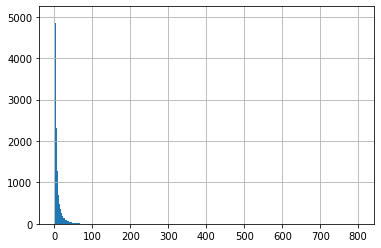

In [173]:
pred.loc[pred.pick_start_date.dt.day == 26, ['pick_start_date', 'pick_end_date', 'pick_time']].pick_time.hist(bins=1000)

In [123]:
pred.corr().se.reindex(intervals)

to_pick                     0.000888
weight                     -0.001034
volume                     -0.000529
box_position_on_cart       -0.000202
timeofday                   0.008042
weekday                    -0.003418
month                            NaN
monthday                    0.001787
picks_done_on_tour          0.000017
items_on_tour               0.000351
weigh_on_tour              -0.000224
volume_on_tour             -0.000296
orders_picking_on_tour     -0.000454
weight_cum_std             -0.000668
volume_cum_std             -0.000228
picks_done_in_order         0.001013
items_in_order              0.000364
weigh_in_order              0.000307
vol_in_order                0.000616
weight_order_cum_std       -0.000598
volume_order_cum_std       -0.000307
total_tour_box_WEISS        0.000406
total_tour_box_SCHWARZ     -0.002445
total_tour_box_GRÜN         0.001476
total_tour_box_ROT          0.001065
total_tour_box_BLAU        -0.000937
total_tour_box_onePos_LX   -0.000477
t

**We need to get rid of outliers.**  
In the big model should consider for how long it can be relevant

### Better model

In [194]:
df_all.pick_time.quantile(0.99)

66.04848716000012

In [7]:
df_all['pick_time_clipped'] = df_all.pick_time.clip(upper=90)

In [8]:
orders = pd.read_csv('data/orders_feats.csv.gz').set_index('los_order_id')
df_all = df_all.merge(orders, how='left', left_on='los_order_id', right_index=True)

In [9]:
tours = pd.read_csv('data/tour_feats.csv.gz').drop(columns='tour_start_date').set_index('tour_id')
df_all = df_all.merge(tours, how='left', left_on='tour_id', right_index=True)

In [10]:
intervals += tours.columns.tolist() + orders.columns.tolist()

In [11]:
del orders, tours

In [12]:
prepr = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categories),
    ('asis', 'passthrough', intervals),
])

In [14]:
X = prepr.fit_transform(df_all.query('is_train and pick_time_clipped < 90'))
Y = df_all.query('is_train and pick_time_clipped < 90').pick_time_clipped.values

In [15]:
X_val = prepr.transform(df_all.query('not is_train'))
Y_val = df_all.query('not is_train').pick_time_clipped.values

In [16]:
xgb = XGBRegressor(random_state=42, verbosity=2, tree_method='gpu_hist',
                   colsample_bytree=0.8, gamma=0.01,
                   subsample=0.3, max_depth=15, sampling_method='gradient_based',
                   n_estimators=1000,
                  )
xgb.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.01, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, sampling_method='gradient_based',
             scale_pos_weight=1, subsample=0.3, tree_method='gpu_hist',
             validate_parameters=1, verbosity=2)

In [17]:
# clipped to 120 -> r2 0.482
xgb.score(X_val, Y_val)

0.49303938326969377

In [18]:
# xgb.save_model('pick_predictor.xgbmodel')

In [19]:
pred = df_all.query('not is_train').copy().assign(
    pt_pred=xgb.predict(X_val),
    se=lambda x: x.pick_time_clipped.sub(x.pt_pred).pow(2),
    pick_start_date=lambda x: pd.to_datetime(x.pick_start_date),
)

In [20]:
fi = pd.Series(xgb.feature_importances_, index=prepr.get_feature_names()
              ).sort_values(ascending=False).iloc[:60]
fi

to_pick              0.001528
onehot__x2_334598    0.001520
onehot__x2_270929    0.001388
onehot__x2_425919    0.001371
onehot__x2_476081    0.001281
weight               0.001127
onehot__x2_304713    0.001085
onehot__x2_979109    0.001026
onehot__x2_314660    0.000955
onehot__x2_857752    0.000947
onehot__x2_468157    0.000946
onehot__x2_340612    0.000889
onehot__x2_477182    0.000863
onehot__x2_39152     0.000839
onehot__x2_645909    0.000827
onehot__x2_814520    0.000812
volume               0.000791
onehot__x2_420673    0.000757
onehot__x2_605348    0.000736
onehot__x2_452789    0.000717
onehot__x2_595420    0.000700
onehot__x2_36945     0.000680
onehot__x2_423040    0.000671
onehot__x2_45639     0.000668
onehot__x2_705944    0.000655
onehot__x2_825938    0.000635
onehot__x2_646364    0.000634
onehot__x2_870975    0.000630
onehot__x2_554210    0.000629
onehot__x2_422450    0.000626
onehot__x2_589961    0.000609
onehot__x2_793985    0.000608
onehot__x2_304576    0.000567
onehot__x2

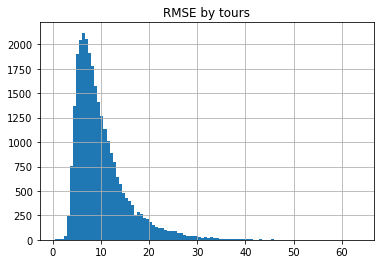

In [21]:
pred.groupby('tour_id').se.mean().pow(0.5).hist(bins=100)
plt.title('RMSE by tours');

In [23]:
pred[['pick_time_clipped', 'pt_pred']].sample(50)

pick_time_clipped    pt_pred
9661149            3.123071   4.620416
9971450            5.818929   5.661814
10514022           4.474152   3.946379
10826869           3.829071   8.886556
10324865           6.091701   3.999964
11355066           2.135791   3.738099
9720082            3.942759   4.305585
9900244            1.689212  20.290316
10155434          14.915245   4.218665
11121027           4.270016   6.362329
11420624           6.424591   4.923166
11259374           8.519035  16.079559
10799336           4.464889   8.115137
11550565           2.767331   4.899140
11632144           8.210104  12.340266
9930906            3.806031   5.381840
11266882           4.877570   3.778334
10202186           8.033896   3.434424
10387071           4.968521   9.332372
10163713           1.113136   3.642988
11741119           1.561308   3.500534
10180818          12.469959  16.310289
10372059          18.004833  12.672630
10937002          11.575336  10.772985
9812272            4.216421   4.982417
11749581           2.651072   4.134821
9663417           45.192758  16.411589
9797189            3.994583   4.054494
11122661          14.018066  10.048998
10094428           4.063398   3.879914
11261422           4.026641   3.759694
11574713          21.870197   8.647606
10890500           2.869777   5.230944
10142665           8.338742  14.891080
11366698          10.350640  19.833466
10949714           3.013866   8.023972
10164495           5.061340   3.135984
11066642          10.912656   3.487162
10179951           4.356938   5.426645
9654357            3.746069   4.194954
11558459          42.612016  32.900288
11324393          10.984157  12.262731
10690439          11.723763  11.246851
10965997           5.074988   4.837269
11743647           3.467315   3.958852
11427999          16.756787  15.798756
11629949           1.592195   5.965126
11655865           2.452807   3.433217
11109668           1.467130   3.580648
11479800           1.963595   3.272632

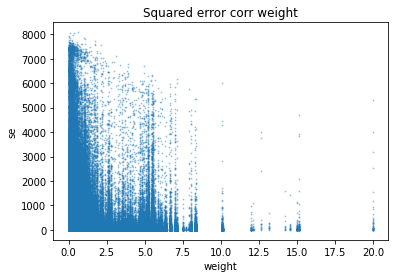

In [24]:
pred.plot('weight', 'se', kind='scatter', alpha=0.3, s=1)
plt.title('Squared error corr weight');

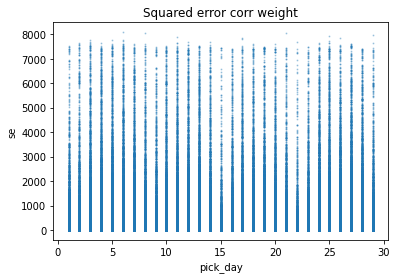

In [32]:
pred.assign(pick_day=lambda x: x.pick_start_date.dt.day
           ).plot('pick_day', 'se', kind='scatter', alpha=0.3, s=1)
plt.title('Squared error corr weight');

## What to do next?

Reduction of article id dimensionality can add accuracy. We can use fully connected network with embeddings for categories for it. Thus expect to capture some information about article.  
  
Another way to deal with articles is to measure time between picks or co-appearence in orders to guess which items are proximate. Can be implemented as social network analysis or collaborative filtering. Or, alternatively, ask for aricle related data.

Alse, we can try to find optimal period of time for training